In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})

In [2]:
exp_data = LorenzExp
initial_state = jnp.array([ -8,8,27.])
dt = 0.025
t_train = jnp.arange(0,10.01,dt)
noise_var = 0.1
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

lorenz_sol = expdata.system_sol
t_train = expdata.t_train

In [3]:
true_sigma2 = 0.05
x_vals = jax.vmap(lorenz_sol.evaluate)(t_train)
x_train = x_vals + (
    jnp.sqrt(true_sigma2) * 
    jax.random.normal(jax.random.PRNGKey(32),(len(t_train),3))
)


num_obs_chain = 10
measurement_vecs = jnp.tile(
    jnp.repeat(jnp.eye(3),num_obs_chain,axis=0),(int(len(t_train)/(num_obs_chain * 3)+1),1))[:len(t_train)]

y_obs = jnp.sum(measurement_vecs*x_train,axis=1)

keep_inds = jnp.where(jnp.arange(0,n_train)%10<7)
measurement_vecs = measurement_vecs[keep_inds]
y_obs = y_obs[keep_inds]
t_train = t_train[keep_inds]

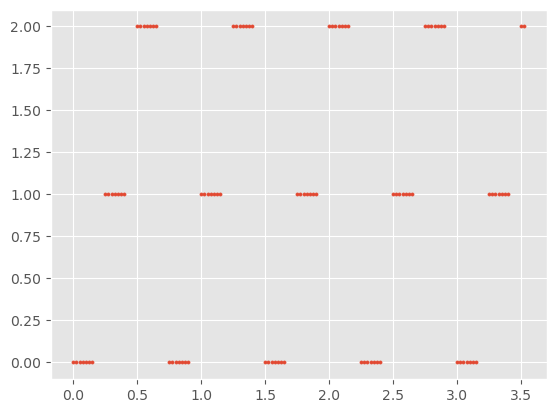

In [4]:
plt.scatter(t_train[:100],jnp.argmax(measurement_vecs,axis=1)[:100],s = 5)

In [7]:
n_colloc = 500
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.25,alpha = 0.01)
    )

In [8]:
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y','z']
)

model.fit(
    t_train,
    t_colloc = None,
    w_colloc = None,
    partialobs_v = measurement_vecs,
    partialobs_y = y_obs,
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.05295983, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Solving for data_weight = 1.0, colloc_weight = 800.0 beta_reg = 0.008


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 1.222e+07, gradnorm = 5.986e+06, alpha = 30.38, improvement_ratio = 0.09892
Iteration 1, loss = 4.289e+06, gradnorm = 8.505e+07, alpha = 30.38, improvement_ratio = 0.6492
Iteration 2, loss = 3.977e+06, gradnorm = 3.281e+07, alpha = 123.0, improvement_ratio = 0.07299
Iteration 3, loss = 2.959e+06, gradnorm = 1.451e+08, alpha = 100.0, improvement_ratio = 0.2564
Iteration 4, loss = 1.242e+06, gradnorm = 6.276e+07, alpha = 100.0, improvement_ratio = 0.5815
Iteration 5, loss = 1.054e+06, gradnorm = 5.302e+07, alpha = 405.0, improvement_ratio = 0.1518
Iteration 100, loss = 815.5, gradnorm = 3.296e+05, alpha = 69.44, improvement_ratio = 0.7614
Iteration 200, loss = 199.5, gradnorm = 2.562e+05, alpha = 11.22, improvement_ratio = 0.6324
Iteration 300, loss = 155.8, gradnorm = 6.931e+05, alpha = 9.346, improvement_ratio = 0.646
Iteration 400, loss = 118.7, gradnorm = 1.322e+06, alpha = 9.346, improvement_ratio = 0.5749
Iteration 500, loss = 74.75, gradnorm = 1.386e+06, alpha 

  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 51.18, gradnorm = 5.782e+04, alpha = 128.1, improvement_ratio = 0.3396
Iteration 1, loss = 45.66, gradnorm = 1.606e+06, alpha = 83.33, improvement_ratio = 0.8871
Iteration 2, loss = 44.14, gradnorm = 1.213e+06, alpha = 69.44, improvement_ratio = 0.9603
Iteration 3, loss = 43.59, gradnorm = 5.53e+05, alpha = 57.87, improvement_ratio = 0.9862
Iteration 4, loss = 43.24, gradnorm = 1.69e+05, alpha = 48.23, improvement_ratio = 0.9929
Iteration 5, loss = 42.96, gradnorm = 6.001e+04, alpha = 40.19, improvement_ratio = 0.9916
Iteration 100, loss = 40.38, gradnorm = 2.295e+04, alpha = 2.174, improvement_ratio = 0.8007
Iteration 200, loss = 40.28, gradnorm = 8.322e+03, alpha = 1.509, improvement_ratio = 0.7352
Iteration 300, loss = 40.24, gradnorm = 1.805e+04, alpha = 0.8735, improvement_ratio = 0.732
Iteration 400, loss = 40.19, gradnorm = 2.791e+04, alpha = 0.728, improvement_ratio = 0.7917
Iteration 500, loss = 40.13, gradnorm = 4.393e+04, alpha = 0.6066, improvement_ratio

  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 57.83, gradnorm = 323.0, alpha = 432.5, improvement_ratio = 0.3181
Iteration 1, loss = 53.15, gradnorm = 1.908e+06, alpha = 100.0, improvement_ratio = 0.7583
Iteration 2, loss = 51.09, gradnorm = 1.658e+06, alpha = 83.33, improvement_ratio = 0.9595
Iteration 3, loss = 50.64, gradnorm = 2.531e+06, alpha = 69.44, improvement_ratio = 0.8734
Iteration 4, loss = 50.3, gradnorm = 2.093e+06, alpha = 57.87, improvement_ratio = 0.8416
Iteration 5, loss = 50.02, gradnorm = 1.536e+06, alpha = 48.23, improvement_ratio = 0.8138
Iteration 100, loss = 47.24, gradnorm = 6.613e+05, alpha = 3.756, improvement_ratio = 0.684
Iteration 200, loss = 46.83, gradnorm = 1.13e+05, alpha = 3.756, improvement_ratio = 0.6832
Iteration 300, loss = 46.74, gradnorm = 2.195e+04, alpha = 1.811, improvement_ratio = 0.7207
Iteration 400, loss = 46.59, gradnorm = 9.211e+05, alpha = 0.2926, improvement_ratio = 0.2311
Iteration 500, loss = 46.51, gradnorm = 5.757e+05, alpha = 0.3511, improvement_ratio = 0

  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 62.17, gradnorm = 1.01e+04, alpha = 346.0, improvement_ratio = 0.09155
Iteration 1, loss = 59.54, gradnorm = 4.865e+06, alpha = 100.0, improvement_ratio = 0.4859
Iteration 2, loss = 58.22, gradnorm = 8.32e+06, alpha = 100.0, improvement_ratio = 0.3927
Iteration 3, loss = 57.5, gradnorm = 2.273e+07, alpha = 100.0, improvement_ratio = 0.3058
Iteration 4, loss = 56.9, gradnorm = 2.701e+07, alpha = 100.0, improvement_ratio = 0.3216
Iteration 5, loss = 56.44, gradnorm = 2.695e+07, alpha = 100.0, improvement_ratio = 0.3202
Iteration 100, loss = 53.53, gradnorm = 7.415e+05, alpha = 33.49, improvement_ratio = 0.8043
Iteration 200, loss = 52.18, gradnorm = 5.325e+05, alpha = 4.507, improvement_ratio = 0.5161
Iteration 300, loss = 52.0, gradnorm = 2.459e+05, alpha = 4.507, improvement_ratio = 0.7331
Iteration 400, loss = 51.94, gradnorm = 3.604e+05, alpha = 2.608, improvement_ratio = 0.7516
Iteration 500, loss = 51.87, gradnorm = 3.626e+05, alpha = 2.174, improvement_ratio = 

In [9]:
model.print()

(x)' = 13.148 1 + -93.268 x + 82.469 y + -4.312 z + 1364.549 x^2 + -2243.365 x y + 5.611 x z + 921.201 y^2 + -5.472 y z
(y)' = 15.626 1 + -121.497 x + 107.081 y + -5.389 z + 1708.601 x^2 + -2807.278 x y + 7.256 x z + 1152.106 y^2 + -7.019 y z
(z)' = 22.835 1 + 35.339 x + -30.085 y + -5.498 z + -604.958 x^2 + 961.358 x y + -12.528 x z + -381.043 y^2 + 10.024 y z


In [10]:
expdata.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


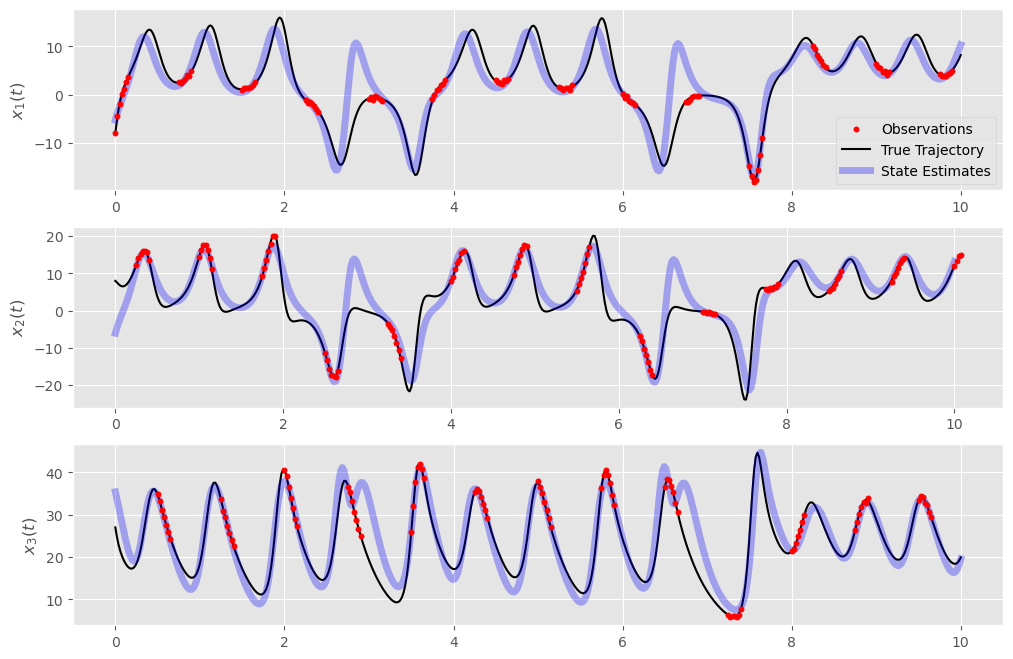

In [11]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
plt.figure(figsize=(12,8))
for dim in range(3):
	plt.subplot(3,1,dim+1)
	obs_index = jnp.where(jnp.argmax(measurement_vecs,axis=1) == dim)
	plt.scatter(t_train[obs_index],y_obs[obs_index],label = 'Observations',s = 14,zorder = 10,c='red')
	plt.plot(t_grid,true_states[:,dim],label = 'True Trajectory',c='black')
	plt.plot(t_grid,state_preds[:,dim],label = 'State Estimates',c ='blue',alpha = 0.3,lw = 5)
	if dim ==0:
		plt.legend()
	plt.ylabel(f"$x_{dim+1}(t)$")